In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


This notebook is to build a basic agentic rag harnessing the langgraph and In this guide we’ll build an app that answers questions about the website's content

In [2]:
import os

os.chdir("../..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/langgraph_ventures


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [5]:
op = await llm.ainvoke("What is the capital of France?")
print(type(op))

<class 'langchain_core.messages.ai.AIMessage'>


In [6]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [7]:
op = await embeddings.aembed_documents(
    ["What is the capital of France?", "What is the capital of Germany?"]
)
print(type(op))

<class 'list'>


In [49]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embeddings.embed_query("hello world"))
print(embedding_dim)
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

3072


In [9]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [10]:
from langgraph.graph import START, StateGraph, END
from typing_extensions import List, TypedDict, Annotated

In [11]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [12]:
print(f"Loaded {len(docs)} documents")

Loaded 1 documents


In [13]:
from IPython.display import display, HTML,Markdown

In [14]:
Markdown(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
all_splits = text_splitter.split_documents(docs)
print(f"Split into {len(all_splits)} chunks")

Split into 66 chunks


In [16]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [17]:
vector_store

In [18]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

In [19]:
Markdown(prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:

In [20]:
prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()


[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: (question goes here) \nContext: (context goes here) \nAnswer:", additional_kwargs={}, response_metadata={})]

In [21]:
class State(TypedDict):
    """State of the agent"""

    question:str
    context:list[Document]
    answer:str

In [22]:
async def retrieve_context(state:State):
    """Retrieve relevant documents from the vector store"""
    question = state["question"]
    context = vector_store.similarity_search(question, k=3)
    # check one context
    # print(context[0])
    return {"context": context}

In [23]:
async def generate_summary(state:State):
    """Generate summary of the retrieved documents"""
    docs_context = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(
        {
            "context": docs_context,
            "question": state["question"],
        }
    )
    respone = await llm.ainvoke(messages)
    return {"answer": respone.content}

In [24]:
# Build the state graph
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve_context", retrieve_context)
graph_builder.add_node("generate_summary", generate_summary)

graph_builder.add_edge(START, "retrieve_context")
graph_builder.add_edge("retrieve_context", "generate_summary")
graph_builder.add_edge("generate_summary",END)

In [25]:
# compile the graph
graph = graph_builder.compile()

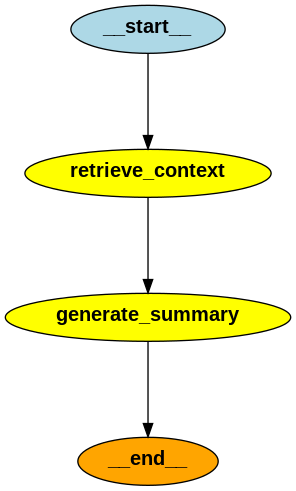

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

In [27]:
# display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
result = await graph.ainvoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b08f258a-74e8-485c-8d61-4f0f24d0e741', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='7609d123-0cc2-4042-a231-2e64cd74cc2d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

In [29]:
async for step in graph.astream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve_context': {'context': [Document(id='b08f258a-74e8-485c-8d61-4f0f24d0e741', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='7609d123-0cc2-4042-a231-2e64cd74cc2d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et

In [30]:
async for message, metadata in graph.astream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Customized Prompt

In [31]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [32]:
async def generate_summary(state:State):
    """Generate summary of the retrieved documents"""
    docs_context = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke(
        {
            "context": docs_context,
            "question": state["question"],
        }
    )
    respone = await llm.ainvoke(messages)
    return {"answer": respone.content}

In [33]:
# Build the state graph
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve_context", retrieve_context)
graph_builder.add_node("generate_summary", generate_summary)

graph_builder.add_edge(START, "retrieve_context")
graph_builder.add_edge("retrieve_context", "generate_summary")
graph_builder.add_edge("generate_summary",END)

In [34]:
# compile the graph
graph = graph_builder.compile()

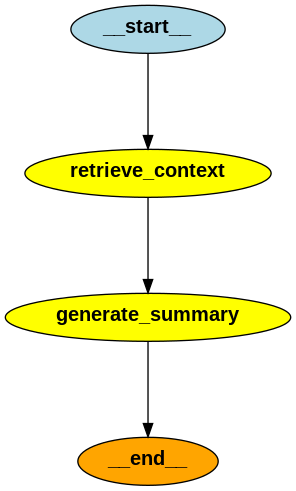

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

In [36]:
result = await graph.ainvoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b08f258a-74e8-485c-8d61-4f0f24d0e741', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='7609d123-0cc2-4042-a231-2e64cd74cc2d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

In [37]:
Markdown(result["answer"])

Task Decomposition is the process of breaking down a complex task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts help enhance model performance by organizing the reasoning process and exploring multiple possibilities for each step. This allows for a more structured approach to problem-solving. Thanks for asking!

Returning Sources along with summarized context

In [38]:
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources used to answer the question",
    ]


In [39]:
class State(TypedDict):
    """State of the agent"""

    question:str
    context:list[Document]
    answer:AnswerWithSources

In [44]:
async def generate_summary(state:State):
    """Generate summary of the retrieved documents and sources"""
    docs_context = "\n\n".join(doc.page_content + "\n"+f"source{doc.metadata['source']}" for doc in state["context"])
    messages = custom_rag_prompt.invoke(
        {
            "context": docs_context,
            "question": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(AnswerWithSources)
    respone = await structured_llm.ainvoke(messages)
    return {"answer": respone}

In [45]:
# Build the state graph
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve_context", retrieve_context)
graph_builder.add_node("generate_summary", generate_summary)

graph_builder.add_edge(START, "retrieve_context")
graph_builder.add_edge("retrieve_context", "generate_summary")
graph_builder.add_edge("generate_summary",END)

In [46]:
# compile the graph
graph = graph_builder.compile()

In [47]:
import json

result = await graph.ainvoke({"question": "What is Chain of Thought?"})
print(json.dumps(result["answer"], indent=2))

{
  "answer": "Chain of Thought (CoT) is a prompting technique that enhances model performance on complex tasks by instructing the model to \"think step by step.\" This approach decomposes large tasks into smaller, manageable steps, allowing for better interpretation of the model's reasoning process. It has become a standard method for improving task execution in language models.",
  "sources": [
    "https://lilianweng.github.io/posts/2023-06-23-agent/"
  ]
}


Hybrid Search

adding random keyword metadata into the original context

In [48]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

In [99]:
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [100]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embeddings.embed_query("hello world"))
print(embedding_dim)
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

3072


In [101]:
# push all documents to the vector store
_ = vector_store.add_documents(documents=all_splits)

In [102]:
from typing_extensions import Literal

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Original Search query to run same as the input query"]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query from the document.",
    ]

In [127]:
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources used to answer the question",
    ]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query from the document.",
    ]


In [128]:
class State(TypedDict):
    """State of the agent"""

    question:str
    query:Search
    context:list[Document]
    answer:AnswerWithSources

In [129]:
async def analyze_query(state:State):
    """Analyze the query and return the section to search"""
    structured_llm = llm.with_structured_output(Search)
    query = await structured_llm.ainvoke(state["question"])
    return {"query": query}

In [130]:
async def retrieve_context(state:State):
    """Retrieve relevant documents from the vector store"""
    print(state)
    query = state["query"]
    context = vector_store.similarity_search(state["question"], k=3, filter= {"section": query["section"]})
    return {"context": context}

In [131]:
async def generate_summary(state:State):
    """Generate summary of the retrieved documents and sources and section"""
    docs_context = "\n\n".join(doc.page_content + "\n"+f"source{doc.metadata['source']}" + "\n"+f"section{doc.metadata['section']}" for doc in state["context"])
    messages = custom_rag_prompt.invoke(
        {
            "context": docs_context,
            "question": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(AnswerWithSources)
    respone = await structured_llm.ainvoke(messages)
    return {"answer": respone}

In [132]:
# Build the state graph
graph_builder = StateGraph(State)
graph_builder.add_node("analyze_query", analyze_query)
graph_builder.add_node("retrieve_context", retrieve_context)
graph_builder.add_node("generate_summary", generate_summary)

graph_builder.add_edge(START, "analyze_query")
graph_builder.add_edge("analyze_query", "retrieve_context")
graph_builder.add_edge("retrieve_context", "generate_summary")
graph_builder.add_edge("generate_summary",END)

In [133]:
# compile the graph
graph = graph_builder.compile()

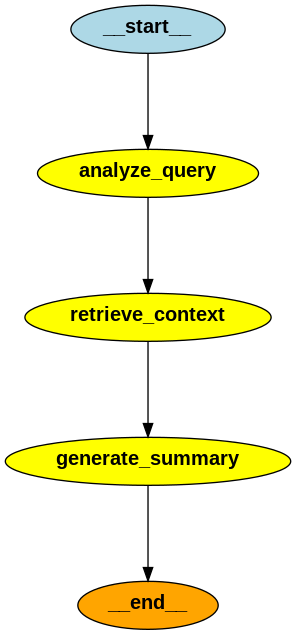

In [134]:
display(Image(graph.get_graph().draw_png()))

In [135]:
import json

result = await graph.ainvoke({"question": "What has been the most important concepts decided at the end of the article?"})
print(json.dumps(result["answer"], indent=2))

{'question': 'What has been the most important concepts decided at the end of the article?', 'query': {'query': 'most important concepts', 'section': 'end'}}
{
  "answer": "The article highlights key limitations of LLM-centered agents, including restricted context length which affects their ability to manage historical information and plan over extended tasks. Challenges in long-term planning and task decomposition were also emphasized, noting that LLMs struggle with adjusting plans in response to unexpected errors. Overall, the importance of developing mechanisms to enhance context handling and learning from errors was underscored.",
  "sources": [
    "https://lilianweng.github.io/posts/2023-06-23-agent/"
  ],
  "section": "end"
}


############################################################ END ############################################################